
# Lab02: Compressed DenseNet for Crowd Counting

> Dataset structure:
> ```
> <DATA_ROOT>/
> ├── Lab02_CDenseNet.ipynb
> ├── CDenseNet.py
> └── data/
>     ├── video/vidf/vidf1_33_ZZZ.y/*.png  # e.g., vidf1_33_ZZZ_fFFF.png ...
>     └── gt/vidf/*.mat    # e.g., vidf1_33_ZZZ_count_2K_roi*.mat ...
> ```

## 0. Mount Google Drive

In [1]:
#from google.colab import drive

# Mount Google Drive
# drive.mount('/content/drive')
# You need to modify this part to the directory where your code is located, i.e., <DATA_ROOT>
# %cd "/content/drive/MyDrive/Lab02/"

## 1. Import Libraries

In [2]:
%pip install torchinfo
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# ---- import library ----
import os, re, glob, random
from typing import List, Tuple, Dict
import numpy as np
from PIL import Image
from scipy.io import loadmat

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms, utils as vutils
import matplotlib.pyplot as plt

%matplotlib inline

def set_global_seed(seed: int):
  # Python
  random.seed(seed)
  # NumPy
  np.random.seed(seed)
  # PyTorch
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  print(f"[INFO] Global seed set to {seed}")

set_global_seed(37)

ModuleNotFoundError: No module named 'torch'

## 2. Dataset Definition

In [ ]:
# File naming for vidf frames: vidf1_33_ZZZ_fFFF.png (ZZZ: 000..019, FFF: 001..200)
FNAME_RE = re.compile(r"vidf1_33_(\d{3})_f(\d{3})\.png")

# Train: 401..2900 | Val: 2901..3600 | Test: 1..400 & 3601..4000
SPLIT_RANGES = {
  "train": [(401, 2900)],
  "val":   [(2901, 3600)],
  # "test":  [(1, 400), (3601, 4000)],   # full test set
  "test":  [(3601, 3800)],             # public test set
}

In [ ]:
class UCSDDataset(Dataset):
  """
  UCSD vidf frames -> (x, people_cnts) where x is grayscale image tensor, people_cnts is [r, l, t] crowd counts for the frame.
  """
  def __init__(self, split: str = "train", transform=None):
    super().__init__()
    assert split in ["train", "val", "test"]
    self.img_dir = './data/video/vidf'
    self.gt_dir  = './data/gt/vidf'

    # preprocess transform: to tensor + normalize to [-1,1]
    self.transform = transform or transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # enumerate frames that belong to this split
    self.items: List[Tuple[int, int, str]] = []  # (clip_idx, f_in_clip, path)
    pngs = sorted(glob.glob(os.path.join(self.img_dir, "**", "*.png"), recursive=True))
    for p in pngs:
      m = FNAME_RE.match(os.path.basename(p))
      if not m:
        continue
      clip_str, f_str = m.groups()
      clip_idx = int(clip_str)           # 000..019
      f_in_clip = int(f_str)             # 001..200
      gidx = clip_idx * 200 + f_in_clip  # global indexing
      for a, b in SPLIT_RANGES[split]:
        if a <= gidx <= b:
          self.items.append((clip_idx, f_in_clip, p))
          break

    # cache for per-clip count .mat files
    self._count_cache: Dict[int, Dict[str, np.ndarray]] = {}

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    clip_idx, f_in_clip, img_p = self.items[idx]
    img = Image.open(img_p).convert('L')
    x = self.transform(img)
    dmap = self._load_counts_clip(clip_idx)
    k = f_in_clip - 1  # 0-based index into 200 frames
    r = dmap.get('r', None)
    l = dmap.get('l', None)
    t = dmap.get('t', None)
    if r is None or l is None or t is None:
      raise KeyError(f"[ERROR] Missing 'r','l','t' in dirs for clip {clip_idx}. Have={list(dmap.keys())}")
    people_cnts = torch.tensor([r[k], l[k], t[k]], dtype=torch.float32)
    return x, people_cnts

  def _load_counts_clip(self, clip_idx: int) -> Dict[str, np.ndarray]:
    """
      Loader for DT mat layout:
       - file:  vidf1_33_ZZZ_count_2K_roi_mainwalkway.mat
       - key:   'cgt' (1x1 struct)
       - fields: cgt.dir (['r','l','t','n']), cgt.count (cell of 4 vectors length 200)
      Returns dict {'r': vec, 'l': vec, 't': vec} as float32.
    """
    if clip_idx in self._count_cache:
      return self._count_cache[clip_idx]

    path = os.path.join(self.gt_dir, f"vidf1_33_{clip_idx:03d}_count_2K_roi_mainwalkway.mat")
    mat = loadmat(path, squeeze_me=False, struct_as_record=False)

    # 1x1 MATLAB struct at key 'cgt'
    entry = mat['cgt'].flat[0]  # get the single struct

    # Access fields
    dirs_raw   = getattr(entry, 'dir')
    counts_raw = getattr(entry, 'count')

    # Normalize to plain Python lists
    dirs_seq   = np.squeeze(dirs_raw).ravel()
    counts_seq = np.squeeze(counts_raw).ravel()

    # Convert names to strings and counts to float arrays
    dirs_list   = [str(np.squeeze(d).item()) for d in dirs_seq]
    counts_list = [np.squeeze(c).astype(np.float32) for c in counts_seq]  # (200,) each

    # Build the map; ignore 'n' (no motion)
    dmap = {}
    for name, vec in zip(dirs_list, counts_list):
      k = name.strip().lower()
      if   k == 'r': dmap['r'] = vec
      elif k == 'l': dmap['l'] = vec
      elif k == 't': dmap['t'] = vec

    missing = [nm for nm in ('r','l','t') if nm not in dmap]
    if missing:
      raise KeyError(f"[ERROR] Missing {missing} in GT for clip {clip_idx}. dirs={dirs_list}")

    # Cache & return
    self._count_cache[clip_idx] = dmap
    return dmap

## 3. Visualize Sample Frames & Labels

Labels [r, l, t] for shown samples:
  #00 -> [8.0, 9.0, 17.0]
  #01 -> [5.0, 8.0, 13.0]
  #02 -> [10.0, 13.0, 23.0]
  #03 -> [8.0, 13.0, 21.0]


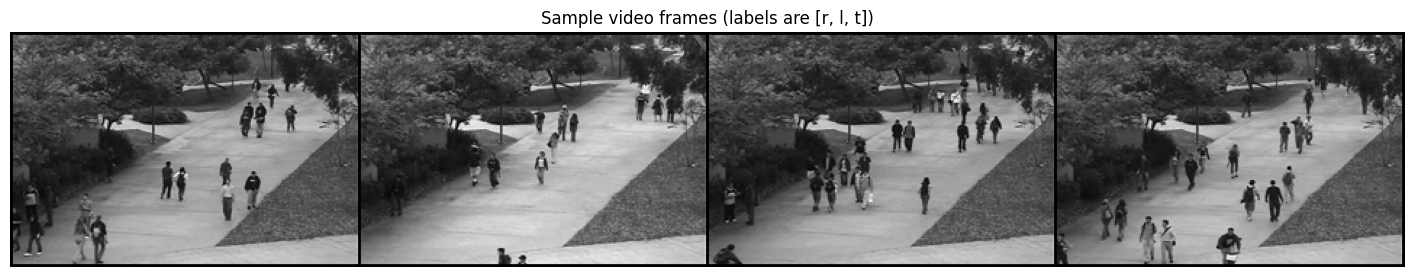

In [ ]:
def visualize_samples(dataset: UCSDDataset, n: int = 4):
  """Show a grid of n sample images and print their [r,l,t] labels."""
  if len(dataset) == 0:
    print("[WARN] Dataset is empty. Please check DATA_ROOT.")
    return

  idxs = [random.randrange(len(dataset)) for _ in range(min(n, len(dataset)))]
  xs, ys = [], []
  for idx in idxs:
    x, people_cnts = dataset[idx]
    xs.append(x)
    ys.append(people_cnts.numpy())

  cols = min(8, len(xs))
  rows = int(np.ceil(len(xs) / cols))
  grid = vutils.make_grid(xs, nrow=cols, normalize=True, scale_each=True)

  plt.figure(figsize=(4.5*cols, 3.8*rows))  # Same scaling as lower function
  plt.axis('off')
  plt.title("Sample video frames (labels are [r, l, t])")
  plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap='gray')

  print("Labels [r, l, t] for shown samples:")
  for i, people_cnts in enumerate(ys):
    print(f"  #{i:02d} -> {[float(f'{v:.2f}') for v in people_cnts.tolist()]}")

try:
  _tmp_ds = UCSDDataset(split="train")
  visualize_samples(_tmp_ds, n=4)
except Exception as e:
  print("[WARN] Visualization skipped:", e)

## 4. Import Model

In [ ]:
from CDenseNet import LDB, CDenseNet

model = CDenseNet(in_channel=1)

In [ ]:
model_summary = summary(model,
                       input_size=(1, 1, 158, 238),
                       device='cuda',
                       depth=9999,  # Large int value to show full depth
                       col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
                       row_settings=["var_names"])

print(model_summary)

with open('summary.txt', 'w') as f:
  f.write(str(model_summary))

print("[INFO] Summary displayed above and saved to summary.txt")

AssertionError: Torch not compiled with CUDA enabled

## 5. Create DataLoaders

In [ ]:
batch_size = 8

# Create dataset instances
train_ds = UCSDDataset(split="train")
val_ds   = UCSDDataset(split="val")
test_ds  = UCSDDataset(split="test")

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

print(f"[INFO] Dataset sizes: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

## 6. Training Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)

# you can try 10~15 at first
num_epochs = 100
# Learning rate
lr = 0.001

# Loss function
criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

## 7. Training Loop

In [ ]:
from tqdm.auto import tqdm

model = model.to(device)

ckpt_path = "model.pth"

mae_best = float('inf')

for epoch in range(1, num_epochs + 1):
  # ---------- Training phase ----------
  model.train()  # Set the model to training mode
  running_loss = 0.0
  train_bar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs} [Train]', leave=False, position=0, smoothing=0.1)
  for in_img, people_cnts in train_bar:
    in_img, people_cnts = in_img.to(device, non_blocking=True), people_cnts.to(device, non_blocking=True)
    
    #################################################
    # Please finish the "Training phase" code here.
    optimizer.zero_grad()                # reset gradients
    outputs = model(in_img)              # forward pass
    loss = criterion(outputs, people_cnts)  # compute loss
    loss.backward()                      # backprop
    optimizer.step()                     # update weights

    #################################################

    running_loss += loss.item() * people_cnts.size(0)
    train_bar.set_postfix(loss=f'{loss.item():.4f}')

  # ---------- Validation phase ----------
  model.eval()  # Set the model to evaluation mode
  val_loss = 0
  # Per-component MAE/RMSE accumulators for [r, l, t]
  abs_sum = torch.zeros(3, dtype=torch.float64)
  sqr_sum = torch.zeros(3, dtype=torch.float64)

  with torch.no_grad():
    val_bar = tqdm(val_loader, desc=f'Epoch {epoch}/{num_epochs} [Val]', leave=False, position=0, smoothing=0.1)
    for in_img, people_cnts in val_bar:
      in_img, people_cnts = in_img.to(device, non_blocking=True), people_cnts.to(device, non_blocking=True)
      
      ###################################################
      # Forward pass for validation
      # Please finish the "Validation phase" code here.
      outputs = model(in_img)              # forward only
      loss = criterion(outputs, people_cnts)
      val_loss += loss.item() * people_cnts.size(0)
      ###################################################

      # Calculate metrics for validation results
      err = outputs - people_cnts
      abs_sum += err.abs().sum(dim=0).double().cpu()
      sqr_sum += (err ** 2).sum(dim=0).double().cpu()
      val_bar.set_postfix(loss=f'{loss.item():.4f}')

  epoch_loss = running_loss / len(train_ds)
  avg_val_loss = val_loss / len(val_ds)
  mae = (abs_sum / len(val_ds)).tolist()
  avg_mae = sum(mae) / 3.0
  rmse = torch.sqrt(sqr_sum / len(val_ds)).tolist()
  avg_rmse = sum(rmse) / 3.0
  if scheduler:
    scheduler.step(avg_mae)

  ckpt_path_epoch = f"model_{epoch}.pth"
  torch.save(model.state_dict(), ckpt_path_epoch)

  if avg_mae < mae_best:
    mae_best = avg_mae
    print("model saved")
    torch.save(model.state_dict(), ckpt_path)

  print(f"[Epoch {epoch:2d}] "
        f"Train Loss: {epoch_loss:8.4f} | "
        f" MAE[r,l,t] = [{mae[0]:7.4f}, {mae[1]:7.4f}, {mae[2]:7.4f}] | "
        f"Avg  MAE: {avg_mae:7.4f}")
  print(f"           "
        f"  Val Loss: {avg_val_loss:8.4f} | "
        f"RMSE[r,l,t] = [{rmse[0]:7.4f}, {rmse[1]:7.4f}, {rmse[2]:7.4f}] | "
        f"Avg RMSE: {avg_rmse:7.4f}")

## 8. Inference on Test Set

In [ ]:
from tqdm.auto import tqdm

_ckpt_path = ckpt_path if 'ckpt_path' in globals() else 'model.pth'
#_ckpt_path = 'model_49.pth'


if os.path.exists(_ckpt_path):
  try:
    # Load checkpoint
    ck = torch.load(_ckpt_path, map_location=device)
    model.load_state_dict(ck)
    print(f"[INFO] Loaded model state dict from checkpoint: {_ckpt_path}")

  except Exception as e:
    print(f"[ERROR] Error loading checkpoint {_ckpt_path}: {e}")
    print("[WARN] Evaluating current in-memory weights.")
else:
  print("[WARN] No checkpoint found; evaluating current in-memory weights.")

model.eval()
abs_sum = torch.zeros(3, dtype=torch.float64)
sqr_sum = torch.zeros(3, dtype=torch.float64)

# Image number to display after testing
num_show = 12
sampled = []
seen = 0

with torch.no_grad():
  test_bar = tqdm(test_loader, desc="Evaluating", leave=False)
  for batch_idx, (in_img, people_cnts) in enumerate(test_bar):
    in_img = in_img.to(device, non_blocking=True)
    people_cnts = people_cnts.to(device, non_blocking=True)
    pred_cnts = model(in_img)

    err = pred_cnts - people_cnts
    abs_sum += err.abs().sum(dim=0).double().cpu()
    sqr_sum += (err**2).sum(dim=0).double().cpu()

    # Reservoir sampling: keep a random 12 from the whole stream
    B = in_img.size(0)
    for i in range(B):
      if len(sampled) < num_show:
        sampled.append((
          in_img[i].detach().cpu(),
          people_cnts[i].detach().cpu(),
          pred_cnts[i].detach().cpu()
        ))
      else:
        j = random.randint(0, seen)
        if j < num_show:
          sampled[j] = (
            in_img[i].detach().cpu(),
            people_cnts[i].detach().cpu(),
            pred_cnts[i].detach().cpu()
          )
      seen += 1

    test_bar.set_postfix({
      'MAE[r, l, t]' : [f"{(abs_sum[i]/((batch_idx + 1) * people_cnts.size(0))):.4f}" for i in range(3)],
      'RMSE[r, l, t]': [f"{(sqr_sum[i]/((batch_idx + 1) * people_cnts.size(0))).sqrt().item():.4f}" for i in range(3)],
    })

# Calculate final metrics
test_mae = (abs_sum / len(test_ds)).tolist()
test_rmse = torch.sqrt(sqr_sum / len(test_ds)).tolist()

# Print results
print(f"[TEST]  MAE[r,l,t] = [{test_mae[0]:.4f}, {test_mae[1]:.4f}, {test_mae[2]:.4f}] | "
      f"Avg  MAE = {(sum(test_mae)/3):.4f}")
print(f"[TEST] RMSE[r,l,t] = [{test_rmse[0]:.4f}, {test_rmse[1]:.4f}, {test_rmse[2]:.4f}] | "
      f"Avg RMSE = {(sum(test_rmse)/3):.4f}")

# Plotting
n = len(sampled)
cols = min(4, n)
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 3.8*rows))
if rows == 1 and cols == 1:
  axes = np.array([[axes]])
elif rows == 1:
  axes = np.array([axes])

for idx, (img, gt, pred) in enumerate(sampled):
  ax = axes[idx // cols, idx % cols]
  img = (img * 0.5 + 0.5).clamp(0, 1).squeeze(0).numpy()
  ax.imshow(img, cmap='gray')
  ax.axis('off')
  gt_np = gt.numpy(); pr_np = pred.numpy(); delta = pr_np - gt_np
  ax.set_title(
    f"PRED [{pr_np[0]:.1f}, {pr_np[1]:.1f}, {pr_np[2]:.1f}]\n"
    f"GT   [{gt_np[0]:.1f}, {gt_np[1]:.1f}, {gt_np[2]:.1f}]\n"
    f"Δ    [{delta[0]:.1f}, {delta[1]:.1f}, {delta[2]:.1f}]",
    fontsize=10, loc='left'
  )

for j in range(n, rows*cols):
  axes[j // cols, j % cols].axis('off')

plt.tight_layout()
plt.show()